In [1]:
import pandas as pd
import bias
%matplotlib inline

# Load the metadata

In [2]:
meta = pd.read_csv("data/metadata/metadata.csv", index_col="PMID")
meta.head(1)

,DOI,KEY,SOURCE,AUTHORS,YEAR,MONTH,JOURNAL,TITLE,PAGES,VOLUME,...,NUM_COORDINATES,MNI_COORDINATES,BRAINMAP_ID,BEHAVIORAL_DOMAIN,EXPERIMENT,DESCRIPTION,IMPACT_FACTOR_2018,CITATIONS,CITATIONS_PER_YEAR,N_SUBJECTS
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,NaN,"Dolan R J, 1992",BrainMap,Dolan R J|Bench C J|Brown R G|Scott L C|Fristo...,1992,Sep,JOURNAL OF NEUROLOGY NEUROSURGERY & PSYCHIATRY,Regional cerebral blood flow abnormalities in ...,768-773,55,...,7.0,"-7.66,51.87,-8.33;-5.51,56.46,-4.28;-5.48,58.9...",6030020.0,"['Action.Rest', 'Action.Rest']","['Unimpaired > Impaired', 'Impaired > Unimpair...",Patients with depression who were cognitively ...,8.327,21,0.75,10.0


## Remove papers with missing data

In [3]:
(~meta["CITATIONS_PER_YEAR"].isna()).astype(int).sum()

18155

In [4]:
meta = meta.dropna(subset=["CITATIONS_PER_YEAR"])
len(meta)

18155

In [5]:
pmids = meta.index
len(pmids)

18155

# Load document-term matrices (DTMs)

In [6]:
from collections import OrderedDict
from style import style

In [7]:
circuits = pd.read_csv("data/brain/clusters_data-driven_lr.csv", index_col=None)
circuits.head()

,ORDER,CLUSTER,DOMAIN,STRUCTURE
0,1,6,MEMORY,left_amygdala
1,1,6,MEMORY,left_hippocampus
2,1,6,MEMORY,left_inferior_temporal_gyrus_anterior_division
3,1,6,MEMORY,left_parahippocampal_gyrus_anterior_division
4,1,6,MEMORY,left_parahippocampal_gyrus_posterior_division


In [8]:
structs, colors, domains = [], [], []
for dom in OrderedDict.fromkeys(circuits["DOMAIN"]):
    dom_structs = circuits.loc[circuits["DOMAIN"] == dom, "STRUCTURE"]
    dom_structs = [struct.replace("left_", "").replace("right_", "").replace("cerebellar_crus", "cerebellum").replace("cerebellar_lobules", "cerebellum").replace("cerebellar_vermis", "cerebellum") for struct in dom_structs]
    dom_structs = list(OrderedDict.fromkeys(dom_structs))
    structs += dom_structs
    colors += [style.c[style.fw2c["data-driven"][style.order["data-driven"].index(dom)]]] * len(dom_structs)
    domains += [dom] * len(dom_structs)

In [9]:
term2colors = {term: [] for term in structs}
for struct in structs:
    for bilat_struct, dom in zip(circuits["STRUCTURE"], circuits["DOMAIN"]):
        bilat_struct = bilat_struct.replace("cerebellar", "cerebellum")
        color = style.c[style.fw2c["data-driven"][style.order["data-driven"].index(dom)]]
        if struct in bilat_struct and color not in term2colors[struct]:
            term2colors[struct].append(color)

## DTM from full texts

In [10]:
dtm_full = pd.read_csv("data/text/dtm_fulltexts_anat-syns.csv.gz", index_col=0)
dtm_full = dtm_full.loc[pmids, structs]
dtm_full.head(5)

,amygdala,hippocampus,inferior_temporal_gyrus_anterior_division,parahippocampal_gyrus_anterior_division,parahippocampal_gyrus_posterior_division,temporal_fusiform_cortex_anterior_division,inferior_temporal_gyrus_posterior_division,temporal_fusiform_cortex_posterior_division,accumbens,brainstem,...,inferior_frontal_gyrus_pars_opercularis,central_opercular_cortex,heschls_gyrus,middle_temporal_gyrus_anterior_division,middle_temporal_gyrus_posterior_division,parietal_operculum_cortex,planum_polare,planum_temporale,superior_temporal_gyrus_anterior_division,superior_temporal_gyrus_posterior_division
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,2,2,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
1486460,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,3,0,0,0,0,1


## DTM from abstracts

In [11]:
dtm_abs = pd.read_csv("data/text/dtm_abstracts_anat-syns.csv.gz", index_col=0)
dtm_abs = dtm_abs.loc[pmids, structs]
dtm_abs.head(5)

,amygdala,hippocampus,inferior_temporal_gyrus_anterior_division,parahippocampal_gyrus_anterior_division,parahippocampal_gyrus_posterior_division,temporal_fusiform_cortex_anterior_division,inferior_temporal_gyrus_posterior_division,temporal_fusiform_cortex_posterior_division,accumbens,brainstem,...,inferior_frontal_gyrus_pars_opercularis,central_opercular_cortex,heschls_gyrus,middle_temporal_gyrus_anterior_division,middle_temporal_gyrus_posterior_division,parietal_operculum_cortex,planum_polare,planum_temporale,superior_temporal_gyrus_anterior_division,superior_temporal_gyrus_posterior_division
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Assess encrichment in top articles

## Compute -log(p)

In [12]:
n = meta["CITATIONS_PER_YEAR"].sort_values(ascending=False)
idx = int(len(n) * (1.0/3.0))
top_n = list(n.index[:idx])
bot_n = list(n.index[idx:])
len(top_n)

6051

In [13]:
len(bot_n)

12104

In [14]:
len(domains)

60

In [15]:
df_full = bias.compute_bias_fdr(dtm_full, domains, top_n, "citations_anat_full")
df_full["TERM"] = [term.replace("_anterior", ",_anterior").replace("_posterior", ",_posterior") for term in df_full["TERM"]]
df_full.sort_values("FDR").head()

,TERM,DOMAIN,P,-log10(P),FDR,ORDER
8,accumbens,REWARD,1.430230e-30,29.844594,8.581380e-29,1
0,amygdala,MEMORY,3.722786e-27,26.429132,1.116836e-25,0
10,caudate,REWARD,1.856563e-25,24.731290,3.713126e-24,1
17,"cingulate_gyrus,_posterior_division",COGNITION,8.848332e-15,14.053139,1.327250e-13,2
16,"cingulate_gyrus,_anterior_division",COGNITION,2.368967e-14,13.625441,2.688054e-13,2


## Plot -log(p)

In [16]:
fdr_thres = 1e-5

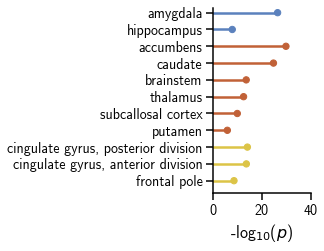

In [17]:
df_full_thres = df_full.loc[df_full["FDR"] < fdr_thres]
bias.plot_dots(df_full_thres, "citations_anat_full", xrange=list(range(0,50,20)), 
               width=1.75, height=0.15*len(df_full_thres) + 1.75, font_size=14)

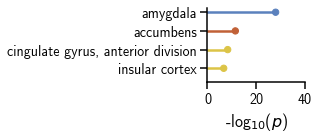

In [18]:
df_abs = bias.compute_bias_fdr(dtm_abs, domains, top_n, "citations_anat_abs")
df_abs["TERM"] = [term.replace("_anterior", ",_anterior").replace("_posterior", ",_posterior") for term in df_abs["TERM"]]
df_abs_thres = df_abs.loc[df_abs["FDR"] < fdr_thres]
bias.plot_dots(df_abs_thres, "citations_anat_abs", xrange=list(range(0,50,20)), 
               width=1.75, height=0.125*len(df_full_thres), font_size=14)

# Plot coordinates vs. full texts

In [19]:
import numpy as np
from style import style

In [20]:
terms = set(dtm_full.columns)
freq = pd.DataFrame({"abstracts": dtm_abs[terms].sum(), "full_texts": dtm_full[terms].sum()})
freq.head()

,abstracts,full_texts
lingual_gyrus,367,15928
inferior_frontal_gyrus_pars_triangularis,106,5110
supplementary_motor_cortex,1380,40204
cuneal_cortex,254,12848
superior_temporal_gyrus_anterior_division,42,1084


In [21]:
term2colors = {struct: [] for struct in structs}
for struct in structs:
    for bilat_struct, dom in zip(circuits["STRUCTURE"], circuits["DOMAIN"]):
        bilat_struct = bilat_struct.replace("cerebellar", "cerebellum")
        color = style.c[style.fw2c["data-driven"][style.order["data-driven"].index(dom)]]
        if struct in bilat_struct and color not in term2colors[struct]:
            term2colors[struct].append(color)

In [22]:
line_func = np.poly1d(np.polyfit(freq["full_texts"], freq["abstracts"], 1))
residuals = []
for x, y in zip(freq["full_texts"], freq["abstracts"]):
    y_pred = line_func(x)
    residual = y - y_pred
    residuals.append(residual)
freq["residual"] = residuals
freq.sort_values("residual", ascending=False).head()

,abstracts,full_texts,residual
cingulate_gyrus_anterior_division,3296,60535,817.993963
insular_cortex,8777,194711,530.379122
amygdala,5389,120420,336.364374
cingulate_gyrus_posterior_division,1331,26127,332.293536
brainstem,1402,30074,233.600575


In [23]:
terms_to_label = list(df_abs_thres["TERM"])
terms_to_label = terms_to_label + [term for term in list(df_full_thres["TERM"]) if term not in terms_to_label]
terms_to_label = [term.replace(",", "") for term in terms_to_label if term.replace(",", "") in freq["residual"].sort_values().index[-3:]]
terms_to_label

['amygdala', 'cingulate_gyrus_anterior_division', 'insular_cortex']

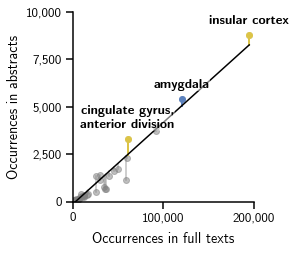

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from style import style

font = style.font
font_bold = style.font_bold

prop_ax = font_manager.FontProperties(fname=font, size=13)
prop_dot = font_manager.FontProperties(fname=font_bold, size=13)
prop_lab = font_manager.FontProperties(fname=font, size=14)

rcParams["axes.linewidth"] = 1.5

fig, ax = plt.subplots(figsize=(3.25, 3.5))

x = freq["full_texts"]
y = freq["abstracts"]

plt.scatter(x, y, color="gray", alpha=0.5)

line_x = np.unique(x)
line_y = line_func(line_x)
for x, y in zip(freq["full_texts"], freq["abstracts"]):
    plt.plot([x, x], [y, line_func(x)], color="gray", alpha=0.5, linewidth=1.5)

nudges = [0, 0, 0]
for i, term in enumerate(terms_to_label):
    row = freq.loc[term]
    x = row["full_texts"]
    y = row["abstracts"]
    label = term.replace("_", " ").replace("cingulate gyrus ", "cingulate gyrus,\n")
    plt.text(x+nudges[i], y+600, label, fontproperties=prop_dot, ha="center",
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="white", linewidth=0, boxstyle="round", pad=0))
    plt.scatter(x, y, color="white", alpha=1)
    plt.plot([x, x], [y, line_func(x)], color="white", alpha=1, linewidth=1.5)
    for color in term2colors[term.replace(",", "")]:
        plt.plot([x, x], [y, line_func(x)], color=color, alpha=1, linewidth=2)
        plt.scatter(x, y, color=color, alpha=1)

plt.plot(line_x, line_y, color="black", alpha=1, linewidth=1.5)
        
ax.set_xticks(range(0, 300000, 100000))
ax.set_yticks(range(0, 12500, 2500))

ax.set_xticklabels([format(v, ",d") for v in range(0, 300000, 100000)], fontproperties=prop_ax)
ax.set_yticklabels([format(v, ",d") for v in range(0, 12500, 2500)], fontproperties=prop_ax)

plt.xlim([0, 200000])
plt.ylim([0, 10000])

for side in ["right", "top"]:
    ax.spines[side].set_visible(False)

ax.xaxis.set_tick_params(width=1.5, length=7)
ax.yaxis.set_tick_params(width=1.5, length=7)

ax.set_xlabel("Occurrences in full texts", fontproperties=prop_lab, labelpad=7.5)
ax.set_ylabel("Occurrences in abstracts", fontproperties=prop_lab, labelpad=5)

plt.savefig("figures/occ_anat_full_abs.png", dpi=250, bbox_inches="tight")
plt.show()

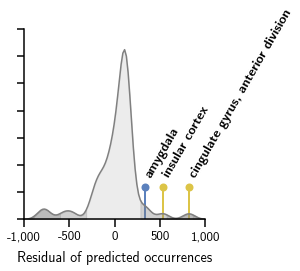

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from style import style
import seaborn as sns

font = style.font
font_bold = style.font_bold

prop_ax = font_manager.FontProperties(fname=font, size=13)
prop_dot = font_manager.FontProperties(fname=font_bold, size=13)
prop_lab = font_manager.FontProperties(fname=font, size=14)

rcParams["axes.linewidth"] = 1.5

fig, ax = plt.subplots(figsize=(3.25, 3.5))

sns.distplot(freq["residual"], hist=False, kde=True, 
             bins=50, color="gray", 
             hist_kws={"edgecolor":"black"},
             kde_kws={"linewidth": 1.5, "color":"gray"})

l = ax.lines[0]
x = l.get_xydata()[:,0]
y = l.get_xydata()[:,1]

mu = np.mean(freq["residual"])
sd = np.std(freq["residual"])

ax.fill_between(x, y, color="gray", alpha=0.15)

for n_sd in range(-3, 0):
    pos = mu + (n_sd * sd)
    closest_x = min(x, key=lambda list_value : abs(list_value - pos))
    idx = list(x).index(closest_x)
    ax.fill_between(x[:idx], y[:idx], color="gray", alpha=0.25)

for n_sd in range(1, 4):
    pos = mu + (n_sd * sd)
    closest_x = min(x, key=lambda list_value : abs(list_value - pos))
    idx = list(x).index(closest_x)
    ax.fill_between(x[idx-1:], y[idx-1:], color="gray", alpha=0.25)

orders = [0, 0, 0]
nudges = [0, 0, 0]
heights = [0.0006, 0.0006, 0.0006]
for i, term in enumerate(terms_to_label):
    row = freq.loc[term]
    x = row["residual"]
    y = heights[i]
    label = term.replace("_", " ").replace("cingulate gyrus ", "cingulate gyrus, ")
    plt.text(x-20+nudges[i], y+0.0002, label, rotation=60, fontproperties=prop_dot, ha="left")
    for color in term2colors[term.replace(",", "")]:
        plt.plot([x, x], [0, y], color=color, linewidth=2, zorder=orders[i])
        plt.scatter(x, y, color=color, linewidth=2, zorder=orders[i])
    
ax.set_xlim([-1000, 1000])
ax.set_ylim([0, 0.0035])

ax.set_xticklabels([format(int(v), ",d") for v in plt.xticks()[0]], 
                   fontproperties=prop_ax, ha="center")
ax.set_yticklabels([], fontproperties=prop_ax)

for side in ["right", "top"]:
    ax.spines[side].set_visible(False)

ax.xaxis.set_tick_params(width=1.5, length=7.5)
ax.yaxis.set_tick_params(width=1.5, length=7.5)

ax.set_xlabel("Residual of predicted occurrences", fontproperties=prop_lab, labelpad=7.5)
ax.set_ylabel("", fontproperties=prop_lab, labelpad=10)

plt.savefig("figures/resid_anat_full_abs.png", dpi=250, bbox_inches="tight")
plt.show()